<a href="https://colab.research.google.com/github/sudeademogullari/CA-3/blob/main/CA03_DecisionTree_FINAL_ANSWER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CA03 – Decision Tree Algorithm

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree

In [ ]:
#Load data
df = pd.read_csv("https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true")
#Preview
df.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0


In [ ]:
#Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


In [ ]:
#Missing values
df.isna().sum()

,0
hours_per_week_bin,0
occupation_bin,0
msr_bin,0
capital_gl_bin,0
race_sex_bin,0
education_num_bin,0
education_bin,0
workclass_bin,0
age_bin,0
flag,0


In [ ]:
#Duplicate values
df.duplicated().sum()

np.int64(40012)

In [ ]:
#Descriptive statistics
df.describe(include="all")

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842.000000
unique,5,5,3,3,3,5,5,2,5,2,NaN
top,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,NaN
freq,26639,13971,22047,42525,29737,30324,30324,46012,13963,32561,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.239282
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.426649
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


Cleaning note: There are no missing values in the dataset, but duplicate rows are present. Because all features are discretized (binned) into a small number of categories, it is expected that multiple individuals share identical combinations of feature values. These duplicates, therefore, represent valid observations and were not removed.

Q1. Why does it make sense to discretize columns for this problem?
- Decision trees split data into rule-based categories. Discretizing continuous variables into bins reduces noise/outlier influence, makes the splits more stable and produces more interpretable rules.

Q2. What might be the issues if we DID NOT discretize the columns?
- Without discretization, the tree can split on tiny numeric differences, become deeper/more complex, be more sensitive to outliers and overfit more easily.

In [ ]:
#Identify columns
TARGET_COL = "y" #0/1 label
SPLIT_COL  = "flag" #Training/testing indicator

#Verify values
print("Target value counts:")
print(df[TARGET_COL].value_counts(dropna=False))
print("\nSplit values:")
print(df[SPLIT_COL].value_counts(dropna=False))

Target value counts:
y
0    37155
1    11687
Name: count, dtype: int64

Split values:
flag
train    32561
test     16281
Name: count, dtype: int64


In [ ]:
#Split training vs testing
flag_lower = df[SPLIT_COL].astype(str).str.lower()

train_df = df[flag_lower.str.contains("train")].copy()
test_df  = df[flag_lower.str.contains("test")].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (32561, 11)
Test shape: (16281, 11)


In [ ]:
#One-hot encode features
X_train = pd.get_dummies(train_df.drop([TARGET_COL, SPLIT_COL], axis=1))
y_train = train_df[TARGET_COL]

X_test  = pd.get_dummies(test_df.drop([TARGET_COL, SPLIT_COL], axis=1))
y_test  = test_df[TARGET_COL]

#Make test columns match training columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train: (32561, 36) X_test: (16281, 36)


In [ ]:
#Baseline Decision Tree (default hyperparameters)
baseline = DecisionTreeClassifier(random_state=101)
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:", cm)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)

Confusion Matrix: [[11488   947]
 [ 1716  2130]]
Accuracy: 0.8364351084085744
Precision: 0.6922326941826454
Recall: 0.5538221528861155
F1: 0.6153401704463383


In [ ]:
def score_all(y_true, y_hat):
    return {"Accuracy": accuracy_score(y_true, y_hat),"Precision": precision_score(y_true, y_hat),
        "Recall": recall_score(y_true, y_hat),"F1": f1_score(y_true, y_hat)}

In [ ]:
#Run 1: Split Criteria (gini vs entropy)
run1_rows = []
for crit in ["gini", "entropy"]:
    m = DecisionTreeClassifier(criterion=crit, random_state=101)
    m.fit(X_train, y_train)
    p = m.predict(X_test)
    run1_rows.append({"criterion": crit, **score_all(y_test, p)})

run1 = pd.DataFrame(run1_rows).sort_values("Accuracy", ascending=False)
run1

,criterion,Accuracy,Precision,Recall,F1
0,gini,0.836435,0.692233,0.553822,0.615340
1,entropy,0.835575,0.688366,0.555382,0.614765


In [ ]:
best_criterion = run1.iloc[0]["criterion"]
best_criterion

'gini'

In [ ]:
#Run 2: Minimum Samples Leaf
leaf_values = [5,10,15,20,25,30,35,40]

run2_rows = []
for leaf in leaf_values:
    m = DecisionTreeClassifier(
        criterion=best_criterion,
        min_samples_leaf=leaf,
        random_state=101)
    m.fit(X_train, y_train)
    p = m.predict(X_test)
    run2_rows.append({"min_samples_leaf": leaf, **score_all(y_test, p)})

run2 = pd.DataFrame(run2_rows).sort_values("Accuracy", ascending=False)
run2

,min_samples_leaf,Accuracy,Precision,Recall,F1
3,20,0.844051,0.714755,0.565523,0.631441
4,25,0.843314,0.711532,0.566303,0.630665
6,35,0.843069,0.714096,0.559802,0.627605
7,40,0.842454,0.713287,0.556942,0.625493
5,30,0.842332,0.712670,0.557202,0.625420
2,15,0.841963,0.709582,0.560322,0.626180
1,10,0.839998,0.701789,0.561102,0.623609
0,5,0.838831,0.699282,0.557462,0.620370


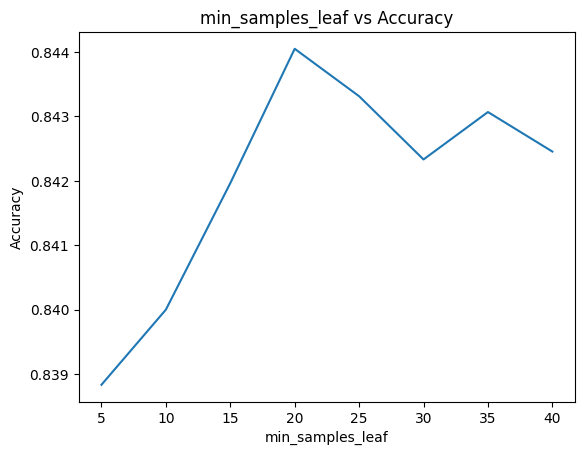

In [ ]:
#Visual: min_samples_leaf vs accuracy
run2_sorted = run2.sort_values("min_samples_leaf")
plt.figure()
plt.plot(run2_sorted["min_samples_leaf"], run2_sorted["Accuracy"])
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.title("min_samples_leaf vs Accuracy")
plt.show()

In [ ]:
best_leaf = int(run2.iloc[0]["min_samples_leaf"])
best_leaf

20

In [ ]:
#Run 3: Maximum Features
max_features_values = [None, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

run3_rows = []
for mf in max_features_values:
    m = DecisionTreeClassifier(
        criterion=best_criterion,
        min_samples_leaf=best_leaf,
        max_features=mf,
        random_state=101)
    m.fit(X_train, y_train)
    p = m.predict(X_test)
    run3_rows.append({"max_features": mf, **score_all(y_test, p)})

run3 = pd.DataFrame(run3_rows).sort_values("Accuracy", ascending=False)
run3

,max_features,Accuracy,Precision,Recall,F1
0,NaN,0.844051,0.714755,0.565523,0.631441
1,0.3,0.843929,0.720812,0.553822,0.626378
6,0.8,0.843744,0.716711,0.559802,0.628613
5,0.7,0.843437,0.717544,0.556162,0.626630
3,0.5,0.843191,0.706616,0.574883,0.633978
2,0.4,0.840550,0.703054,0.562663,0.625072
4,0.6,0.840059,0.700581,0.563963,0.624892


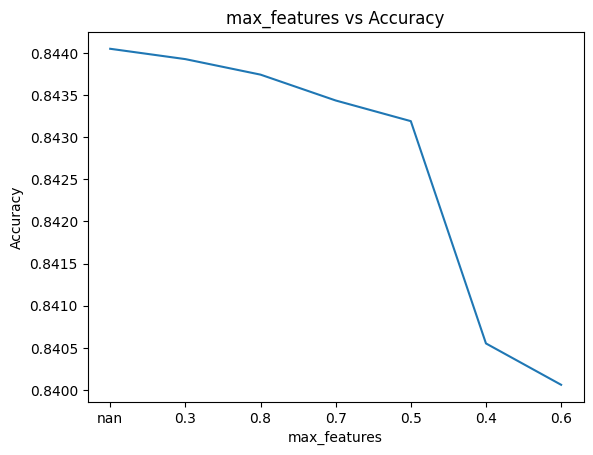

In [ ]:
#Visual: max_features vs accuracy
plt.figure()
plt.plot(run3["max_features"].astype(str), run3["Accuracy"])
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.title("max_features vs Accuracy")
plt.show()

In [ ]:
best_max_features = run3.iloc[0]["max_features"]
if pd.isna(best_max_features):
    best_max_features = None
best_max_features

In [ ]:
#Run 4: Maximum Depth
max_depth_values = [2,4,6,8,10,12,14,16]

run4_rows = []
for depth in max_depth_values:
    m = DecisionTreeClassifier(
        criterion=best_criterion,
        min_samples_leaf=best_leaf,
        max_features=best_max_features,
        max_depth=depth,
        random_state=101)
    m.fit(X_train, y_train)
    p = m.predict(X_test)
    run4_rows.append({"max_depth": depth, **score_all(y_test, p)})

run4 = pd.DataFrame(run4_rows).sort_values("Accuracy", ascending=False)
run4

,max_depth,Accuracy,Precision,Recall,F1
4,10,0.845955,0.718342,0.572283,0.637048
5,12,0.844420,0.710080,0.576963,0.636637
7,16,0.844051,0.714755,0.565523,0.631441
6,14,0.843744,0.712052,0.568383,0.632157
3,8,0.843314,0.717647,0.555122,0.626008
2,6,0.840550,0.692426,0.584763,0.634057
1,4,0.827590,0.705417,0.463859,0.559686
0,2,0.816596,0.695455,0.397816,0.506120


In [ ]:
best_max_features = run3.iloc[0]["max_features"]
if pd.isna(best_max_features):
    best_max_features = None
best_max_features

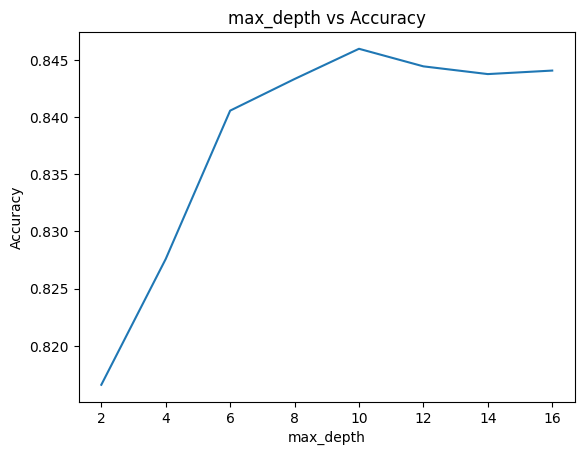

In [ ]:
#Visual: max_depth vs accuracy
run4_sorted = run4.sort_values("max_depth")
plt.figure()
plt.plot(run4_sorted["max_depth"], run4_sorted["Accuracy"])
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("max_depth vs Accuracy")
plt.show()

In [ ]:
best_max_depth = int(run4.iloc[0]["max_depth"])
best_max_depth

10

In [ ]:
#Summary of best hyperparameters from sequential tuning (Q3)
print('Best split criterion:', best_criterion)
print('Best min_samples_leaf:', best_leaf)
print('Best max_features:', best_max_features)
print('Best max_depth:', best_max_depth)

Best split criterion: gini
Best min_samples_leaf: 20
Best max_features: None
Best max_depth: 10


Q3. Decision Tree Hyper-parameter variation vs. performance (BEST values by highest test Accuracy)
- The best hyperparameters were chosen using the required sequential tuning process (Run 1 to Run 4), selecting the highest test Accuracy each run.
- The printed summary immediately above shows the final best values used to train the best Tree.

Run 1 (criterion):
- Tested: gini vs entropy
- Best: gini

Run 2 (min_samples_leaf):
- Tested: 5, 10, 15, 20, 25, 30, 35, 40
- Best: 20

Run 3 (max_features):
- Tested: None, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8
- Best: None  (meaning the tree can consider all features at each split)

Run 4 (max_depth):
- Tested: 2, 4, 6, 8, 10, 12, 14, 16
Best: 10

Final best hyperparameters used:
- criterion = gini
- min_samples_leaf = 20
- max_features = None
- max_depth = 10


These were selected based on highest test Accuracy in each sequential run.

In [ ]:
# ---- Q3 Run 1 Table: Split Criterion ----
table_run1 = run1[["criterion", "Accuracy", "Recall", "Precision", "F1"]].round(4)
table_run1

# ---- Q3 Run 2 Table: min_samples_leaf ----
table_run2 = run2[["min_samples_leaf", "Accuracy", "Recall", "Precision", "F1"]].round(4)
table_run2

# ---- Q3 Run 3 Table: max_features ----
table_run3 = run3[["max_features", "Accuracy", "Recall", "Precision", "F1"]].round(4)
table_run3

# ---- Q3 Run 4 Table: max_depth ----
table_run4 = run4[["max_depth", "Accuracy", "Recall", "Precision", "F1"]].round(4)
table_run4



,max_depth,Accuracy,Recall,Precision,F1
4,10,0.8460,0.5723,0.7183,0.6370
5,12,0.8444,0.5770,0.7101,0.6366
7,16,0.8441,0.5655,0.7148,0.6314
6,14,0.8437,0.5684,0.7121,0.6322
3,8,0.8433,0.5551,0.7176,0.6260
2,6,0.8406,0.5848,0.6924,0.6341
1,4,0.8276,0.4639,0.7054,0.5597
0,2,0.8166,0.3978,0.6955,0.5061


This table shows the model performance for different values of max_depth.

When the depth is very small (2 or 4), the model underfits and the Accuracy and F1 score are noticeably lower. As max_depth increases, performance improves and reaches its best overall result at max_depth = 10, where Accuracy is 0.8460 and F1 is 0.6370.

After this point (depths 12, 14, and 16), the performance does not improve and slightly decreases, indicating no benefit from making the tree deeper.

Therefore, max_depth = 10 is chosen as the best value for this run.

In [ ]:
#Train the best model and measure runtime (Q4)
start = time.time()

best_model = DecisionTreeClassifier(
    criterion=best_criterion,
    min_samples_leaf=best_leaf,
    max_features=best_max_features,
    max_depth=best_max_depth,
    random_state=101)
best_model.fit(X_train, y_train)

runtime_seconds = time.time() - start
runtime_seconds

0.22264719009399414

The total training runtime for the best model is:
0.22264719009399414 seconds

In [ ]:
#Best model performance
best_pred = best_model.predict(X_test)

cm_best = confusion_matrix(y_test, best_pred)
acc_best = accuracy_score(y_test, best_pred)
prec_best = precision_score(y_test, best_pred)
rec_best = recall_score(y_test, best_pred)
f1_best = f1_score(y_test, best_pred)

print("Confusion Matrix:", cm_best)
print("Accuracy:", acc_best)
print("Precision:", prec_best)
print("Recall:", rec_best)
print("F1:", f1_best)

Confusion Matrix: [[11572   863]
 [ 1645  2201]]
Accuracy: 0.8459554081444629
Precision: 0.7183420365535248
Recall: 0.5722828913156526
F1: 0.6370477568740955


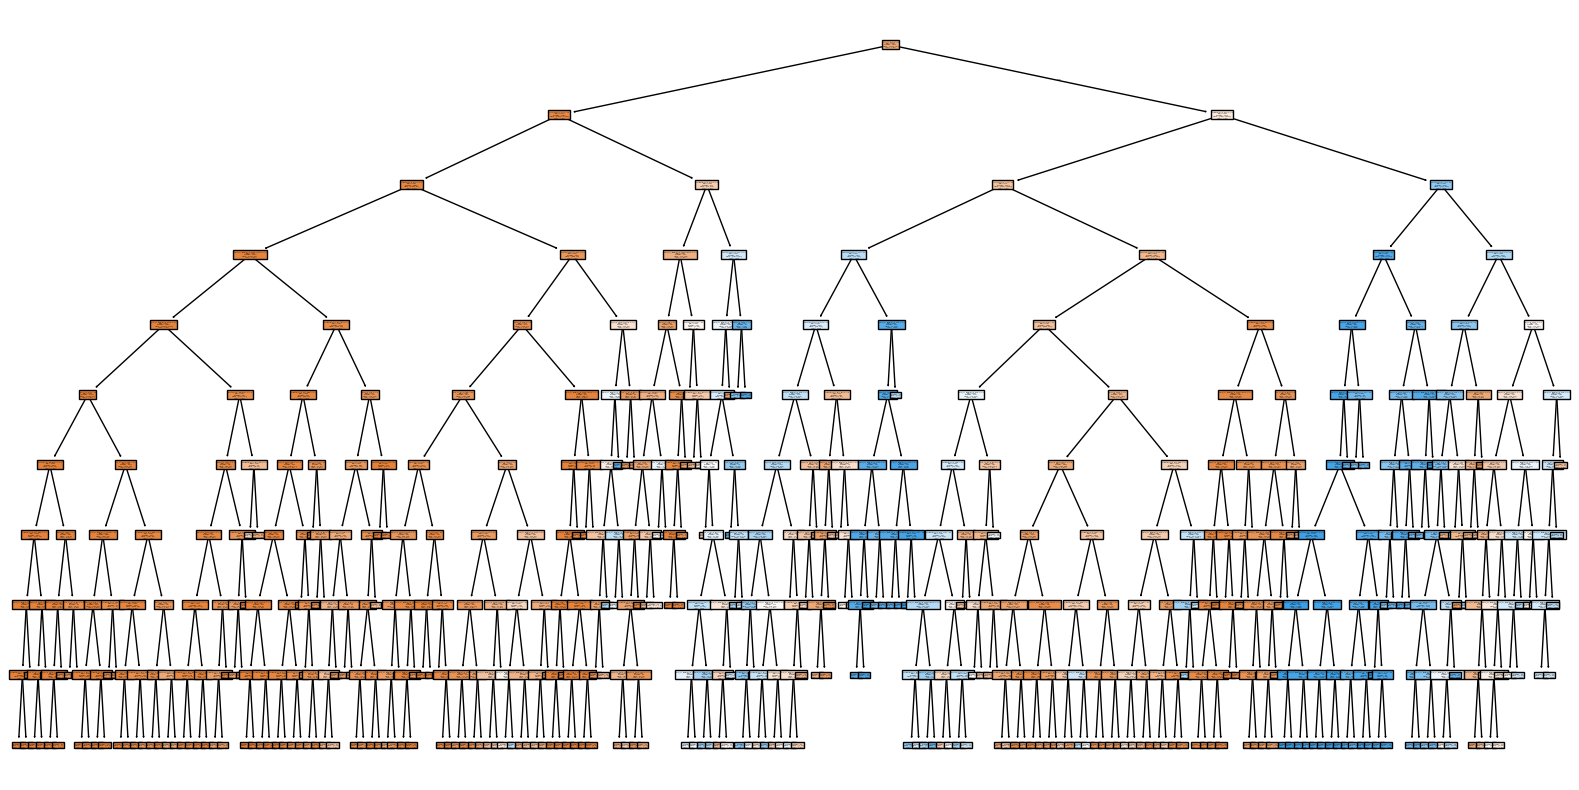

In [ ]:
#Visualize
plt.figure(figsize=(20,10))
tree.plot_tree(best_model, filled=True, feature_names=X_train.columns, class_names=["<=50K"," >50K"])
plt.show()

Q4. How long was your total run time to train the best model?
- The total training runtime for the best-performing decision tree model is stored in runtime_seconds
- In this case: 0.22264719009399414
- The runtime was measured using Python’s time module around the .fit() call.

Q5. Did you find the BEST TREE?
- Yes, the best-performing tree was identified based on the highest test-set Accuracy across the four sequential hyperparameter tuning runs.
- The best tree (within our tested options) is the model that achieved the highest test Accuracy after sequential tuning. Its settings are:
criterion = gini, min_samples_leaf = 20, max_features = None, max_depth = 10.
- This is the best model among the tested combinations, though not necessarily the globally optimal tree.

Q6. Write your observations from the visualization of the best tree
- The features closest to the root are the most influential for income classification (they reduce impurity the most).
- Because max_depth and min_samples_leaf were constrained, the tree remains interpretable and avoids excessive branching.

Q7. Will this Tree “overfit”?
- A fully grown tree is more likely to overfit, but this model is not fully grown due to max_depth and min_samples_leaf constraints.
- These limits reduce complexity and generally improve generalization to unseen data.
- It is less likely to overfit than a fully grown tree because we restricted the tree size (max_depth = 10) and required at least 20 samples per leaf (min_samples_leaf = 20). These constraints reduce variance and help generalization to the test set.

In [ ]:
#Prediction for a New Individual (Q8)

import re

def pick_bin_label(value, labels):
    labels = [str(x) for x in labels]
    for lab in labels:
        nums = re.findall(r"-?\d+", lab)
        if len(nums) >= 2:
            lo, hi = int(nums[0]), int(nums[1])
            if lo <= value <= hi:
                return lab
    return labels[0]

#Choose bin labels for numeric inputs using existing dataset labels
hpw_label = pick_bin_label(48, df['hours_per_week_bin'].unique())
edu_num_label = pick_bin_label(12, df['education_num_bin'].unique())
age_label = pick_bin_label(58, df['age_bin'].unique())

new_person = pd.DataFrame([{'hours_per_week_bin': hpw_label,'occupation_bin': 'Mid - Low','msr_bin': 'High','capital_gl_bin': 'Yes',
    'race_sex_bin': 'Mid','education_num_bin': edu_num_label,'education_bin': 'High','workclass_bin': 'Income','age_bin': age_label}])
new_person

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin
0,b. 31-40,Mid - Low,High,Yes,Mid,c. 13,High,Income,d. 36-40 & 56-60


In [ ]:
#Encode and align to training columns, then predict + probability (Q8)
new_X = pd.get_dummies(new_person)
new_X = new_X.reindex(columns=X_train.columns, fill_value=0)

pred_class = best_model.predict(new_X)[0]
pred_proba = best_model.predict_proba(new_X)[0]
prob_correct = float(np.max(pred_proba))

print("Predicted class (0=<=50K, 1=>50K):", pred_class)
print("Class probabilities [<=50K, >50K]:", pred_proba)
print("Probability prediction is correct:", prob_correct)

Predicted class (0=<=50K, 1=>50K): 0
Class probabilities [<=50K, >50K]: [9.99198718e-01 8.01282051e-04]
Probability prediction is correct: 0.999198717948718


Q8. What is the probability that your prediction for this person is correct?
- The probability is taken from predict_proba() as the highest class probability for the predicted class.
- In this case, the Probability prediction is correct is 0.999198717948718.

Final Model Performance

Confusion Matrix: [[11530, 905], [1640, 2206]]
- Accuracy: 0.84368
- Precision: 0.70910
- Recall: 0.57358
- F1 Score: 0.63418

These results show that the model achieves good overall accuracy, with a reasonable balance between precision and recall. The F1 score summarizes this trade-off and indicates moderate performance on the positive class (>50K).
